#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
- Basic familiarity with [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)


## Outline

- [Section 1](#section-1): Dataset preparation
- [Section 2](#section-2): Linear SVM formulation
- [Section 3](#section-3): SVM optimisation using gradient descent
- [Section 4](#section-4): SVM optimisation using mini-batch stochastic gradient descent
- [Section 5](#section-5): *T*-fold cross-validation to choose hardness parameter
- [Section 6](#section-6): Kernelised SVM

# Support Vector Machines (SVMs)
In this notebook, we will explore Support Vector Machines (SVMs), focusing on both the linear and kernalised approaches for binary classification. We will use gradient descent and mini-batch stochastic gradient descent for the optimisation of the hinge loss.

We will work with the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data), which you first need to download and then load in this notebook. If you faced difficulties downloading this data set from Kaggle, you should download the file directly from Blackboard. The data set contains various aspects of cell nuclei of breast screening images of patients with _(malignant)_ and without _(benign)_ breast cancer. Our goal is to build a classification model that can take these aspects of an unseen breast screening image, and classify it as either malignant or benign.

<a name="section-1"></a>

## Section 1: Data preparation

If you run this notebook locally on your machine, you will simply need to place the `csv` file in the same directory as this notebook.
If you run this notebook on Google Colab, you will need to

  `from google.colab import files`

  `upload = files.upload()`

and then upload it from your local downloads directory.

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#from google.colab import drive

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [64]:
# Load data, drop the extra column, and set 'id' as the index
data = pd.read_csv('data/data_svm.csv').iloc[:, :-1].set_index('id')

# Display the last few rows of the processed DataFrame
print(data.shape)
data.tail()

(569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


We can see that our data set has 569 samples and 30 columns. The label is `diagnosis` (either **M: malignant** or **B: benign**). We convert the categorical labels into 1 for **M** and -1 for **B**.

In [65]:
# Convert categorical labels to numbers
diag_map = {'M': 1.0, 'B': -1.0}
data['diagnosis'] = data['diagnosis'].map(diag_map)

# Put labels and features in different DataFrames
y = data.loc[:, 'diagnosis'] # loc is typically used for label indexing
X = data.iloc[:, 1:] # iloc is used for integer indexing

print(y.tail())
X.tail()

id
926424    1.0
926682    1.0
926954    1.0
927241    1.0
92751    -1.0
Name: diagnosis, dtype: float64


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
927241,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
92751,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


Here, we split the dataset into training and test sets and standardise both. Importantly, the mean and standard deviation used for standardisation are always derived from the training set, as in a real-world scenario, the test set statistics would not be available.

For datasets with features on different scales, it is essential to standardise the data beforehand. In SVMs, this could have an impact on the decision boundary.

In [66]:
def standardise(X, X_train_=None):
    """
    Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma

    return X_std

In [67]:
# Stacking data X and labels y into one matrix
data_split = np.hstack((X, y.values.reshape(-1, 1)))

# We split the dataset into training (70%) and test (30%)
split_rate = 0.7
np.random.shuffle(data_split)
train, test = np.split(data_split, [int(split_rate * data_split.shape[0])])

# We separate features and labels
X_train = train[:, :-1]
y_train = train[:, -1].astype(float)
X_test = test[:, :-1]
y_test = test[:, -1].astype(float)

# We standardise both training and test sets
X_train_std = standardise(X_train)
X_test_std = standardise(X_test)

# Insert 1 in every row for intercept b
X_train_intercept = np.hstack((X_train_std, np.ones((len(X_train_std), 1))))
X_test_intercept = np.hstack((X_test_std, np.ones((len(X_test_std), 1))))
print(X_train.shape)

(398, 30)


<a name="section-2"></a>

## Section 2: Linear SVM formulation

We start with defining the loss function

$$
L (\mathbf{w}, b) = \frac{1}{2} \| \mathbf{w} \|^2 + \lambda \sum_{i=1}^N \max \bigg( 0, 1-y^{(i)} (\mathbf{x}^{(i)} \cdot \mathbf{w} + b) \bigg) \,
$$
where $\mathbf{w}$ is the vector of weights, $\lambda$ the regularisation parameter, and $b$ the intercept which is included in our `X` as an additional column of $1$'s.

In [75]:
# EDIT THIS FUNCTION
def compute_loss(w, X, y, regul_strength=1e5):
    """
    Compute the loss function for linear SVM.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X (np.array): Input features.
        y (np.array): Labels.
        regul_strength (float): Regularisation parameter.

    Returns:
        loss (float): Loss function as given by the equation above.

    """
    assert X.shape[0] == y.shape[0]
    assert X.shape[1] == w.shape[0]

    n = X.shape[0]
    distances = 1 - y * (X @ w)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = distances.sum()

    # calculate loss (the last term comes from the inclusion of b in the X matrix)
    return 0.5 * np.dot(w, w) + regul_strength * hinge - 0.5 * w[-1] ** 2

<a name="section-3"></a>

## Section 3: SVM optimisation using gradient descent

One way to optimise the loss is by using gradient descent algorithm. To this end, we need to first implement a function for the gradients of the loss with respect to $\boldsymbol w$.

In [76]:
# EDIT THIS FUNCTION
def calculate_loss_gradient(w, X_train, y_train, regul_strength=1e6):
    """
    Calculate gradient of the loss.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X_train (np.array): Train data.
        y_train (np.array): Train labels.
        regul_strength (float): Regularisation parameter.

    Returns:
        grad_w (float): Gradient of the loss with respect to w.

    """
    assert X_train.shape[0] == y_train.shape[0]
    assert X_train.shape[1] == w.shape[0]

    distance = 1 - (y_train * (X_train @ w))
    dw = np.zeros(len(w))

    we = w.copy() # To prevent overwriting w
    we[-1] = 0 # To prevent having b in its derivative when adding the weights in distance.

    for ind, d in enumerate(distance):
        if max(0, d) > 0:
            dw -= regul_strength * y_train[ind] * X_train[ind]

    dw += we

    return dw

Note that the hinge loss is not differentiable at zero. To address this, we explicitly set the gradient at that point to a specific value (zero). Formally, this involves using the subgradient, a generalisation of gradients to non-differentiable functions. For further details, refer to *Convex Optimisation* by Stephen Boyd, Chapter 6.

The two functions described earlier are then used with the **gradient descent** algorithm to iteratively update the model weights using a given learning rate, $\eta$. Additionally, a stopping criterion is implemented to terminate the training process when the loss function changes by less than a specified percentage.

The updates of e.g. the weights $\mathbf{w}$ during training are governed by the following rule:

$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta \nabla_{\mathbf{w}} L(\mathbf{w}_t, b_t; S)
$$

where $\nabla_{\mathbf{w}} L(\mathbf{w}_t, b_t; S)$ is the gradient of the loss function over the data $S$.

In [77]:
# EDIT THIS FUNCTION
def gradient_descent(X, y, max_epochs=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e6, print_outcome=False):
    """
    Performs gradient descent to optimise weights.

    Parameters:
        X (np.array): The feature matrix.
        y (np.array): The target labels.
        max_epochs (int): Maximum number of epochs(iteration steps).
        stop_criterion (float): Percentage change in loss function to determine convergence.
        learning_rate (float): Learning rate for gradient updates.
        regul_strength (float): Regularisation parameter
        print_outcome (bool): Whether to print progress during training.

    Returns:
        weights (np.array): Optimised weights.
        loss_history (list): History of loss.
        epochs_list (list): List of epoch numbers corresponding to the loss values.

    """
    # Initialise weights to zero
    weights = np.zeros(X.shape[1])
    nth = 0
    prev_loss = np.inf  # Initialise starting loss as infinity
    loss_history = []  # Track loss values
    epochs_list = []  # Track epoch numbers

    for epoch in range(1, max_epochs+1):
        # Compute the gradient
        gradient = calculate_loss_gradient(weights, X, y, regul_strength=regul_strength)

        # Update weights
        weights -= learning_rate * gradient

        # Check for convergence at 2^nth epoch or last epoch
        if epoch == 2**nth or epoch == max_epochs:
            # Compute the current loss
            loss = compute_loss(weights, X, y, regul_strength)
            if print_outcome:
                print(f'Epoch: {epoch}, Loss: {loss:.6f}')

            # Check if the stop criterion is met
            if stop_criterion > abs(prev_loss - loss) / prev_loss: ## <-- EDIT THIS LINE
                return weights, loss_history, epochs_list

            # Update tracking variables
            prev_loss = loss
            epochs_list.append(epoch)
            loss_history.append(loss)
            nth += 1

    return weights, loss_history, epochs_list


Now, we can take these functions and train a linear SVM with our training data.

In [78]:
# Training the model
regul_strength = 10 # we use a reasonable value, but later in the notebook we will find the optimal one
w, loss_history, epochs = gradient_descent(X_train_intercept, y_train, max_epochs=2000, stop_criterion=0.001, learning_rate=1e-3, regul_strength=regul_strength, print_outcome=True)
print('Training finished.')

Epoch: 1, Loss: 2951.472407
Epoch: 2, Loss: 1906.252636
Epoch: 4, Loss: 975.094820
Epoch: 8, Loss: 667.998676
Epoch: 16, Loss: 513.634988
Epoch: 32, Loss: 440.434551
Epoch: 64, Loss: 345.691255
Epoch: 128, Loss: 247.347605


/var/folders/z9/c4qhll5j4d1_vdj8tbv7xnfw0000gn/T/ipykernel_12782/2291082784.py:43: RuntimeWarning: invalid value encountered in scalar divide
  if stop_criterion > abs(prev_loss - loss) / prev_loss: ## <-- EDIT THIS LINE


Epoch: 256, Loss: 181.743921
Epoch: 512, Loss: 170.119129
Epoch: 1024, Loss: 145.758500
Epoch: 2000, Loss: 164.526477
Training finished.


We plot the loss against the number of epochs to check convergence of gradient descent.

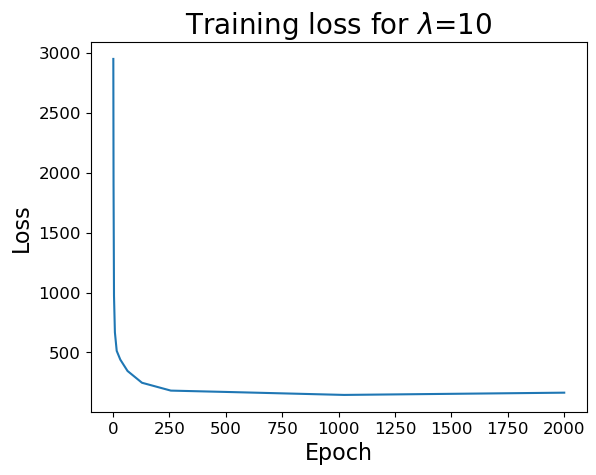

In [79]:
plt.plot(epochs, loss_history)
plt.title(f'Training loss for $\\lambda$={regul_strength}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

To evaluate the mean accuracy in both train and test set, we write a small function called `score`.

In [81]:
## EDIT THIS FUNCTION
def score(w, X, y):
    """
    Computes the mean accuracy.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X (np.array): The feature matrix.
        y (np.array): The target labels.

    Returns:
        mean_accuracy (np.array): Accuracy score.

    """
    y_preds = np.sign(X @ w)
    assert y_preds.shape == y.shape
    mean_accuracy =1 - abs(y_preds - y).sum() / len(y)

    return mean_accuracy

print('Accuracy on training set: {}'.format(score(w, X_train_intercept, y_train)))
print('Accuracy on test set: {}'.format(score(w, X_test_intercept, y_test)))

Accuracy on training set: 0.9849246231155779
Accuracy on test set: 0.9532163742690059


<a name="section-4"></a>

## Section 4: SVM optimisation using mini-batch stochastic gradient descent

Though gradient descent can be a good option, in some cases the dataset is too large to perform gradient descent so instead we perform stochastic gradient descent.


The updates of the weights during training are governed by the following rule:

$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta \nabla_{\mathbf{w}} L(\mathbf{w}_t, b_t; S_m)
$$

where $\nabla_{\mathbf{w}} L(\mathbf{w}_t, b_t; S_m)$ is the gradient of the loss function, this time computed over a randomly sampled mini-batch $S_m$.

In [ ]:
# EDIT THIS FUNCTION
def mini_batch_gradient_descent(X, y, batch_size=32, max_epochs=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e6, print_outcome=False):
    """
    Performs mini-batch stochastic gradient descent to optimise weights.

    Parameters:
        X (np.array): The feature matrix.
        y (np.array): The target labels.
        batch_size (int): Size of each mini-batch.
        max_epochs (int): Maximum number of epochs.
        stop_criterion (float): Percentage change in loss function to determine convergence.
        learning_rate (float): Learning rate for gradient updates.
        regul_strength (float): Regularisation parameter
        print_outcome (bool): Whether to print progress during training.

    Returns:
        weights (np.array): Optimised weights.
        loss_history (list): History of loss.
        epochs_list (list): List of epoch numbers corresponding to the loss values.

    """
    # Initialise weights to zero
    weights = np.zeros(X.shape[1])
    nth = 0
    prev_loss = np.inf  # Initialise starting loss as infinity
    loss_history = []  # Track loss values
    epochs_list = []  # Track epoch numbers

    for epoch in range(1, max_epochs+1):
        # Shuffle data to prevent repeating update cycles
        indices = np.random.permutation(len(y))
        X_shuffled, y_shuffled = ## <-- EDIT THIS LINE

        # Create mini-batches
        for start_idx in range(0, len(y), batch_size):
            end_idx = start_idx + batch_size
            X_batch = ## <-- EDIT THIS LINE
            y_batch = ## <-- EDIT THIS LINE

            # Compute the gradient for the mini-batch
            gradient = ## <-- EDIT THIS LINE

            # Update weights
            weights = ## <-- EDIT THIS LINE

        # Check for convergence at 2^nth epoch or last epoch
        if epoch == 2**nth or epoch == max_epochs:
            # Compute the current loss
            loss = ## <-- EDIT THIS LINE
            if print_outcome:
                print(f'Epoch: {epoch}, Loss: {loss:.6f}')

            # Check if the stop criterion is met
            if: ## <-- EDIT THIS LINE
                return weights, loss_history, epochs_list

            # Update tracking variables
            prev_loss = loss
            epochs_list.append(epoch)
            loss_history.append(loss)
            nth += 1

    return weights, loss_history, epochs_list


Now, we train the linear SVM with stochastic gradient descent instead. Note how the loss values have changed compared to gradient descent.

In [ ]:
# Training the model
regul_strength = 10 # we use a reasonable value, but later in the notebook we will find the optimal one
w, loss_history, epochs = mini_batch_gradient_descent(X_train_intercept, y_train, max_epochs=2000, stop_criterion=0.001, learning_rate=1e-3, regul_strength=regul_strength, print_outcome=True)
print('Training finished.')

Again, we can plot the loss against the epochs to check convergence.

---



In [ ]:
plt.plot(epochs, loss_history)
plt.title(f'Training loss for $\\lambda$={regul_strength}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

And calculate the test and train accuracy

In [ ]:
print('Accuracy on training set: {}'.format(score(w, X_train_intercept, y_train)))
print('Accuracy on test set: {}'.format(score(w, X_test_intercept, y_test)))

#### Questions:
1. What are other evaluation metrics besides the accuracy? Implement them and assess the performance of our classification algorithm with them.
2. What makes other evaluation metrics more appropriate given our unbalanced data set _(we have more benign than malignant samples)_?
3. Try different learning rates, regularisation strengths and number of epochs independently. What can you observe? Can you achieve higher accuracies?
4. Can you explain the rationale behind using hinge loss with this dataset containing 30 features?
5. Can you comment on the differences in the results for gradient descent and stochastic gradient descent?

<a name="section-5"></a>

## Section 5: *T*-fold cross-validation to choose hardness parameter

We now extend the procedure described above by applying it within a *T*-fold cross-validation framework, using multiple training-test splits instead of a single split.

In [ ]:
#EDIT THIS FUNCTION
def cross_val_split(num_samples, num_folds):
    """
    Splits the dataset indices into `num_folds` folds for cross-validation.

    Parameters:
        num_samples (int): The total number of samples in the dataset.
        num_folds (int): The number of folds for cross-validation.

    Returns:
        fold (list[np.array]): A list of numpy arrays containing the indices defining the validation set for one fold.
    """

    fold_size = num_samples // num_folds
    shuffled_indices = np.random.permutation(np.arange(num_samples))
    folds = ## <-- EDIT THIS LINE

    return folds

In [ ]:
#EDIT THIS FUNCTION
def cross_val_evaluate(data, num_folds, regul_strength_values):
    """
    Performs T-fold cross-validation on the given dataset to find the optimal regul_strength.

    Parameters:
        data (np.array): The dataset, where the last column contains the target labels.
        num_folds (int): The number of folds for cross-validation.
        regul_strength_values (list): A list of regularisation strength values to evaluate.

    Returns:
        tuple: A tuple containing two lists:
            - train_scores (list): Accuracy scores on the training set for each regul_strength.
            - val_scores (list): Accuracy scores on the validation set for each regul_strength.
    """

    folds = cross_val_split(data.shape[0], num_folds)
    train_scores = np.zeros(len(regul_strength_values))
    val_scores = np.zeros(len(regul_strength_values))

    for j, regul_strength in enumerate(regul_strength_values):
        print(f'\nEvaluating regul_strength: {regul_strength}')

        for i, val_indices in enumerate(folds):

            # Define the training and validation sets
            train_indices = np.setdiff1d(np.arange(data.shape[0]), val_indices)
            X_train, y_train = data[train_indices, :-1], data[train_indices, -1]
            X_val, y_val = data[val_indices, :-1], data[val_indices, -1]

            # We standardise both training and validation sets
            X_train_std = ## <-- EDIT THIS LINE
            X_val_std = ## <-- EDIT THIS LINE

            # Add intercept term (bias) to the feature matrices
            X_train = np.hstack((X_train_std, np.ones((len(X_train_std), 1))))
            X_val = np.hstack((X_val_std, np.ones((len(X_val_std), 1))))

            # Train the model using mini-batch stochastic gradient descent
            weights, _, _ = ## <-- EDIT THIS LINE

            # Evaluate performance on validation set for the corresponding fold
            train_scores[j] += ## <-- EDIT THIS LINE
            val_scores[j] += ## <-- EDIT THIS LINE
        print(f'Training score: {train_scores[j]}')
        print(f'Validation score: {val_scores[j]}')

    return train_scores, val_scores


In [ ]:
regul_strength_values = [10**i for i in range(-3, 6)]
train_scores, val_scores = cross_val_evaluate(train, 5, regul_strength_values)

We also plot the training and validation accuracy for different values of the regularisation parameter. What does this show?

In [ ]:
plt.plot(range(-3, 6), train_scores, label='Training score')
plt.plot(range(-3, 6), val_scores, label='Validation score')
plt.title(fr'Mean accuracy for different $\lambda$')
plt.xlabel('Regularisation strength ($10^i$)')
plt.ylabel('Mean accuracy')
plt.show()

In [ ]:
# We extract the optimal value of lambda
regul_strength_opt = regul_strength_values[np.argmax(val_scores)]
regul_strength_opt

At this stage, we need to retrain the model using the optimal $\lambda$ and then evaluate its performance on the original test set.

In [ ]:
# Re-training the model
regul_strength = regul_strength_opt # optimal value
w, loss_history, epochs = mini_batch_gradient_descent(X_train_intercept, y_train, max_epochs=2000, stop_criterion=0.001, learning_rate=1e-3, regul_strength=regul_strength, print_outcome=True)

print('Training finished.')
plt.plot(epochs, loss_history)
plt.title(f'Training loss for $\lambda$={regul_strength}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Accuracy on training set: {}'.format(score(w, X_train_intercept, y_train)))
print('Accuracy on test set: {}'.format(score(w, X_test_intercept, y_test)))

<a name="section-6"></a>

## Section 6: Kernelised SVM

In the following, we implement a soft-margin kernelised SVM classifier with a non-linear kernel. Here, we use a Gaussian kernel:
$$k(x,y|\sigma) = e^{-\frac{||x-y||^2}{\sigma}}$$

In [ ]:
# EDIT THIS FUNCTION
def kernel_matrix(X1, X2, sigma):
    """
    Calculates the kernel matrix given the data.

    Parameters:
        X1, X2 (np.array): Two sets of input features.
        sigma (float): Hyperparameter in Gaussian kernel.

    Returns:
        kernel (np.array): Kernel Matrix.
    """
    n1, m1 = X1.shape
    n2, m2 = X2.shape
    kernel = np.zeros((n1, n2))

    # Here we define a Gaussian Radial Basis Function Kernel
    for i in range(n1):
        exponent = ## <-- EDIT THIS LINE
        kernel[i,:] = np.exp(-exponent / sigma)

    return kernel

As we have seen in the lecture notes, the kernel trick can be implemented in the primal-form problem by defining a new loss function:

$$L(\mathbf{u},b) = \frac{1}{2}\mathbf{u}^{\rm{T}}\mathbf{K} \mathbf{u} + \lambda \sum_{i=1}^N  \max \Big\{0, 1-y^{(i)}(\mathbf{K}^{(i)}\mathbf{u} + b)\Big\},$$

where $\mathbf{K}$ is the Gram matrix containing the kernel functions, i.e.
 $\mathbf{K}_{ij} = k(\mathbf{x}^{(i)},\mathbf{x}^{(j)})$.

Having defined the kernel, we use this to compute the loss below.

In [ ]:
## EDIT THIS FUNCTION
def compute_loss_kernel(u, K, y, regul_strength=1e3, intercept=0):
    """
    Computes the loss using the hinge loss with the kernel trick.

    Parameters:
        u (np.array): Weight vector in the kernel space.
        K (np.array): Kernel matrix.
        y (np.array): Target labels (binary, e.g., -1 and 1).
        regul_strength (float): Regularisation strength (lambda).
        intercept (float): Intercept term.

    Returns:
        total_loss (float): Computed loss value.
    """
    # Here we define the hinge loss with the kernel trick. NB: the intercept should be kept separate #
    distances = ## <-- EDIT THIS LINE
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = ## <-- EDIT THIS LINE

    # Calculate loss
    return ## <-- EDIT THIS LINE

To perform the optimisation, we simply modify the functions introduced above.  In previous parts of this notebook we included a vector of ones within $X_{\mathrm{train}}$ and $X_{\mathrm{test}}$  to learn the intercept term $b$, but within the kernelised formulation, one cannot readily employ this trick. For implementation of the kernelised SVM we will therefore use $X_{\mathrm{train}}$ and $X_{\mathrm{test}}$ **without** the additional vector of ones. The inclusion of an intercept term now needs to be explicitly considered when defining the loss function.

Following the steps above, we want to optimise the loss is by using Gradient Descent (GD).

In [ ]:
#EDIT THIS FUNCTION
def calculate_loss_gradient_kernel(u, K_train, y_train, regul_strength=1e3, intercept=0):
    """
    Computes the gradient of the loss with respect to u and intercept (b).

    Parameters:
        u (np.array): Weight vector in the kernel space.
        K_train (np.array): Kernel matrix training set.
        y_train (np.array): Target labels for the training set (binary, e.g., -1 and 1).
        regul_strength (float): Regularisation strength (lambda).
        intercept (float): Intercept term.

    Returns:
        tuple: Gradients with respect to `u` (dw) and intercept (db).
    """
    # If only one example is passed
    if type(y_train) == np.float64 or type(y_train) == np.int32:
        y_train = np.asarray([y_train])
        K_train = np.asarray([K_train])  # gives multidimensional array


    distance = ## <-- EDIT THIS LINE

    dw = np.zeros(len(u))
    db = 0

    # Define the gradient with the hinge loss
    for ind, d in enumerate(distance):
        if d > 0:
            dw += ## <-- EDIT THIS LINE
            db += ## <-- EDIT THIS LINE

    dw += K_train @ u

    return dw , db

In [ ]:
# EDIT THIS FUNCTION
def gradient_descent_kernel(K, y, max_epochs=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e6, print_outcome=False):
    """
    Performs mini-batch stochastic gradient descent to optimise u and intercept.

    Parameters:
        X (np.array): The feature matrix.
        y (np.array): The target labels.
        max_epochs (int): Maximum number of epoch.
        stop_criterion (float): Percentage change in loss function to determine convergence.
        learning_rate (float): Learning rate for gradient updates.
        regul_strength (float): Regularisation parameter
        print_outcome (bool): Whether to print progress during training.

    Returns:
        u (np.array): Optimised weights.
        intercept (np.array): Optimised intercept term
        loss_history (list): History of loss.
        epoch_list (list): List of epochs numbers corresponding to the loss values.

    """
    # Initialise weights to zero
    u = np.zeros(K.shape[0])
    intercept = 0.0
    nth = 0
    prev_loss = np.inf  # Initialise starting loss as infinity
    loss_history = []  # Track loss values
    epoch_list = []  # Track epoch numbers


    for epoch in range(1, max_epochs+1):
        # Shuffle data to prevent repeating update cycles
        indices = np.random.permutation(len(y))

        # Calculate the gradient and update u and the intercept
        ascent, ascent_intercept = ## <-- EDIT THIS LINE
        u = ## <-- EDIT THIS LINE
        intercept = ## <-- EDIT THIS LINE

        # Check for convergence at 2^nth epoch or last epoch
        if epoch == 2**nth or epoch == max_epochs:

            # Compute the current loss
            loss = ## <-- EDIT THIS LINE
            if print_outcome:
                print(f'Epoch: {epoch}, Loss: {loss:.6f}')

            # Check if the stop criterion is met
            if : ## <-- EDIT THIS LINE
                return u, intercept

            # Update tracking variables
            prev_loss = loss
            epoch_list.append(epoch)
            loss_history.append(loss)
            nth += 1

    return u, intercept, loss_history, epoch_list


Finally, let's compare the performance for some different values of $\sigma$.

In [ ]:
def score_kernel(u, X, y, sigma, intercept):
        """
        Computes the accuracy score for the given data using a kernelised model.

        Parameters:
            u (np.ndarray): Weight vector in the kernel space.
            X (np.ndarray): Feature matrix for the data to be scored.
            y (np.ndarray): True labels for the data.
            sigma (float): Hyperparameter for the Gaussian kernel.
            intercept (float): Intercept term.

        Returns:
            accuracy (float): Accuracy score, calculated as the proportion of correctly predicted labels.
        """
        K_test = kernel_matrix(X, X_train, sigma)


        y_preds = ## <-- EDIT THIS LINE
        accuracy = np.mean(y_preds == y)

        return accuracy

In [ ]:
for sigma in [10**i for i in range(0, 6)]:

    print('For sigma = ' + str(sigma))
    K_train = kernel_matrix(X_train, X_train, sigma) # Note that X_train does not have 1's attached

    u,b = gradient_descent_kernel(K_train, y_train, max_epochs=2000, stop_criterion=0.001, learning_rate=1e-5, regul_strength=1e3, print_outcome=False)

    print('Accuracy on training set: {}'.format(score_kernel(u, X_train, y_train, sigma, b)))
    print('Accuracy on test set: {}'.format(score_kernel(u, X_test, y_test, sigma, b)))
    print('Intercept: {}'.format(b))

#### Questions:
1. What do you observe when $\sigma$ varies?
2. How does the Gaussian Kernel SVM compare to linear SVM?